## Model Testing

Runs model on the test set. Includes output metrics and multiple graphs detailing our results. 

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os
import pandas as pd
from scipy.io import loadmat
import glob
import visualkeras
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import signal
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

In [2]:
#Subjects used for testing were placed in a seperate folder; use base path to define location of testing subject videos

base_path = os.getcwd() #change path based on location of testing folder
videos = glob.glob(os.path.join(base_path,"subject*/vid.avi"))
subjects_test =  []

for i in videos:
    subject_number = i[-10:-8]
    try:
        subject_number = subject_number.replace('t','')
    except:
        pass
    subjects_test.append(f"subject{subject_number}")

print(subjects_test)

In [3]:
X_test = []
y_test = []
for subject in tqdm(subjects_test):
    iterate = len(glob.glob(f"{base_path}/{subject}/Map*"))
    for i in range(1,iterate+1):
        img_path_rgb = os.path.join(base_path, subject, f'Map{i}', 'img_rgb.png')
        img_path_yuv = os.path.join(base_path, subject, f'Map{i}', 'img_yuv.png')
        
        img_rgb = load_img(img_path_rgb,color_mode = 'rgb')
        img_yuv = load_img(img_path_yuv, color_mode = 'rgb')
        combined_image = np.concatenate((img_rgb, img_yuv),axis = -1)
        
        X_test.append(combined_image)
        
        bvp_path = os.path.join(base_path,subject, f'Map{i}', 'bvp.mat')
        bvp_data = loadmat(bvp_path)
        bvp =  bvp_data['bvp'][0]
        
        y_test.append(bvp)
    
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape)
print(y_test.shape)

100%|██████████| 11/11 [00:03<00:00,  3.57it/s]

(1768, 63, 256, 6)
(1768, 256)


In [4]:
model = tf.keras.models.load_model("UNet rPPG/Training Output/trained_rPPG_U-Net_take2.keras") #change to saved location of model

In [5]:
y_pred = model.predict(X_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 589ms/step


In [6]:
print(y_pred.size)

452608


In [7]:
evaluation = model.evaluate(X_test,y_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 572ms/step - loss: 0.2843 - mean_squared_error: 0.2843 - root_mean_squared_error: 0.5322


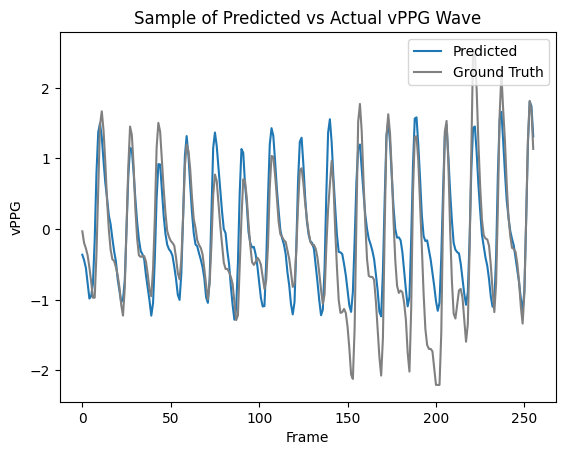

In [8]:
plt.plot(y_pred[1])
plt.plot(y_test[1],color='0.5')
plt.title("Sample of Predicted vs Actual vPPG Wave")
plt.xlabel("Frame")
plt.ylabel("vPPG")
plt.legend(["Predicted","Ground Truth"],loc='upper right')

In [9]:
def calculate_HR(y):
    fs = 30;
    f,Pxx = signal.welch(y,fs,nperseg=256,nfft=4096)
    #plt.plot(f,Pxx)
    #plt.xlabel("frequency")
    #plt.ylabel("Power Spectral Density")
    #plt.title("PSD")
    min_freq = 0.67
    max_freq = 4.0
    range_index = np.where((f>=min_freq) & (f <= max_freq))[0]
    in_range = Pxx[range_index]

    max_index = np.argmax(in_range)
    
    HR = f[range_index][max_index]
    bpm = HR * 60.0

    return bpm

In [10]:
calculate_HR(y_pred[1])

110.7421875

In [12]:
HR_pred = []
HR_true = []
for i in y_pred:
    HR_pred.append(calculate_HR(i))

for i in y_test:
    HR_true.append(calculate_HR(i))

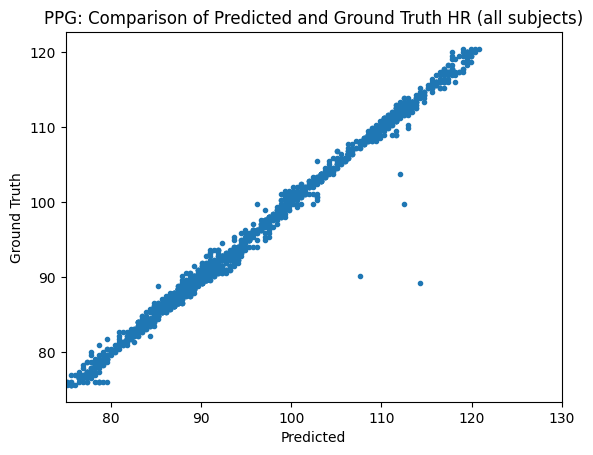

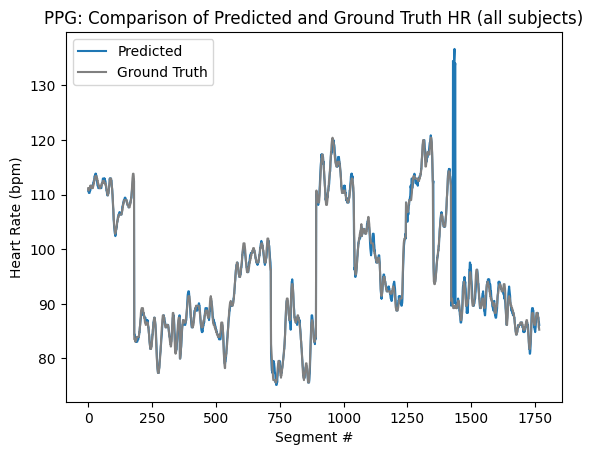

In [13]:
plt.figure()
plt.plot(HR_pred,HR_true,'.')
plt.title("PPG: Comparison of Predicted and Ground Truth HR (all subjects)") 
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.xlim([75,130])

plt.figure()
plt.plot(HR_pred)
plt.plot(HR_true,color = '0.5')
plt.title("PPG: Comparison of Predicted and Ground Truth HR (all subjects)") 
plt.xlabel("Segment #")
plt.ylabel("Heart Rate (bpm)")
plt.legend(["Predicted","Ground Truth"])
#plt.figure()
#plt.plot(HR_pred[537:716]) #subject 41; performed quite badly
#plt.plot(HR_true[537:716])
#plt.title("Subject 41 HR Values")

In [14]:
mae = mean_absolute_error(HR_true,HR_pred)
rmse = np.sqrt(mean_squared_error(HR_true,HR_pred))
r,_ = pearsonr(HR_true,HR_pred)

In [15]:
print(mae, rmse, r) #MAE, RMSE, and r for all subjects (EXCLUDING subject 41)

0.731510490313914 3.0545242957651397 0.9651346514137162


## Metrics for Subject 41, which did not perform well:

In [16]:
X_41 = []
y_41 = []

subject = "subject41"

iterate_41 = len(glob.glob(f"{base_path}/subject41/Map*"))
for i in range(1,iterate_41+1):
    img_path_rgb = os.path.join(base_path, subject, f'Map{i}', 'img_rgb.png')
    img_path_yuv = os.path.join(base_path, subject, f'Map{i}', 'img_yuv.png')
    
    img_rgb = load_img(img_path_rgb,color_mode = 'rgb')
    img_yuv = load_img(img_path_yuv, color_mode = 'rgb')
    combined_image = np.concatenate((img_rgb, img_yuv),axis = -1)
    
    X_41.append(combined_image)
    
    bvp_path = os.path.join(base_path,subject, f'Map{i}', 'bvp.mat')
    bvp_data = loadmat(bvp_path)
    bvp =  bvp_data['bvp'][0]
    
    y_41.append(bvp)
    
X_41 = np.array(X_41)
y_41 = np.array(y_41)
print(X_41.shape)
print(y_41.shape)

(179, 63, 256, 6)
(179, 256)


In [17]:
model = tf.keras.models.load_model("UNet rPPG/Training Output/trained_rPPG_U-Net_take2.keras") #change to saved location of model

In [18]:
y_pred_41 = model.predict(X_41)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 623ms/step


In [19]:
evaluation = model.evaluate(X_41,y_41)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 545ms/step - loss: 0.8733 - mean_squared_error: 0.8733 - root_mean_squared_error: 0.9331


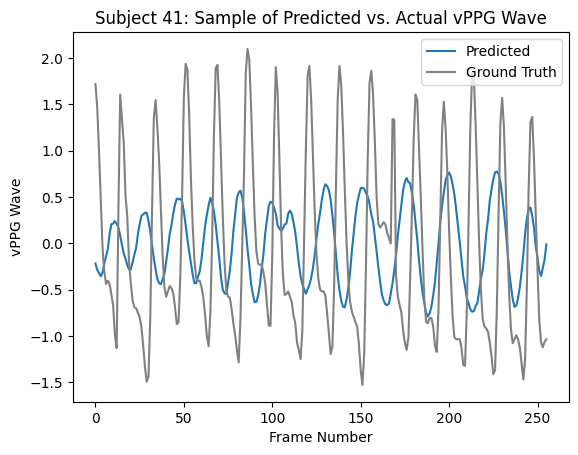

In [20]:
plt.plot(y_pred_41[66])
plt.plot(y_41[66],color='0.5')
plt.xlabel("Frame Number")
plt.ylabel("vPPG Wave")
plt.title("Subject 41: Sample of Predicted vs. Actual vPPG Wave")
plt.legend(["Predicted","Ground Truth"])

In [21]:
HR_pred_41 = []
HR_true_41 = []
for i in y_pred_41:
    HR_pred_41.append(calculate_HR(i))

for i in y_41:
    HR_true_41.append(calculate_HR(i))

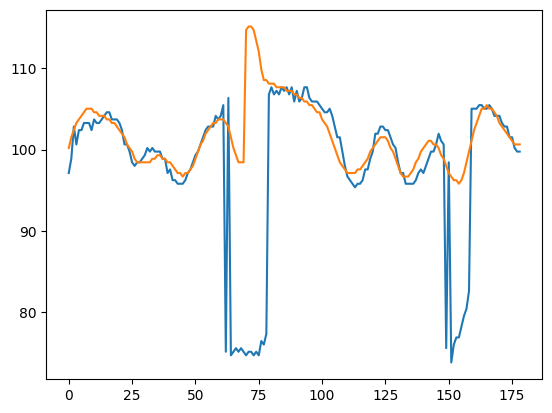

In [22]:
plt.figure()
plt.plot(HR_pred_41)
plt.plot(HR_true_41)

In [23]:
mae41 = mean_absolute_error(HR_true_41,HR_pred_41)
rmse41 = np.sqrt(mean_squared_error(HR_true_41,HR_pred_41))
r41,_ = pearsonr(HR_true_41,HR_pred_41)

In [24]:
print(mae41, rmse41, r41) #MAE, RMSE, and r for subject 41

4.7112321054469275 10.675744770101108 0.05937590687521144
